# Score-based generative models

## Introduction

Generative modelling is a fundamental problem in machine learning, where, given a dataset of samples (e.g. images of dogs), one is tasked with learning a model that can generate new samples that are similar to the ones in the dataset (e.g. new images of dogs).
More precisely speaking, given a dataset of $N$ examples $\{x^{(1)}, \dots, x^{(N)}\}$, the goal of generative modelling is to train a model to generate new examples $x$ that are generated by the latent [probability density function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function) of the dataset $p(x)$ that generated the data.

In the past decade, several models have been proposed for this task; two notable examples are [variational autoencoders (VAEs)](https://arxiv.org/abs/1312.6114) and [generative adversarial networks (GANs)](https://arxiv.org/abs/1406.2661).
VAEs fall into the category of *likelihood-based models*, where a parametric model $\hat p(\theta, x)$ with parameters $\theta$ is trained to approximate the data PDF $p(x)$ by maximizing the likelihood of the data under the model $\hat p(\theta, x)$.
GANs, on the other hand, are *implicit models*, where the model is trained to generate samples that are indistinguishable from the data.
It is well-known that implicit models are notoriously difficult to train due to adverserial training, and often suffer from mode collapse, where the model only learns to generate a subset of the data distribution (see e.g. [here](https://arxiv.org/abs/1606.03498)).
It is also well-known that likelihood-based models must either restrict their architecture to ensure a tractable normalizing constant, which can limit their expressivity (see e.g. [here](https://arxiv.org/abs/2101.03288)), or approximate the normalizing constant which can be computationally intensive.

Recently, score-based models have been proposed, achieving state-of-the-art results on many tasks (see e.g. [here](https://arxiv.org/abs/1907.05600) and [here](https://arxiv.org/abs/2011.13456)) and alleviating some of the issues of likelihood-based and implicit models. The key idea of score-based models is to learn the gradient of the log-likelihood of the data $\nabla \log p(x)$, which is called the *score* of the data, which does not require a tractable normalizing constant (as you will see in Task 1) and can be used to generate new samples using, e.g. Langevin dynamics (see e.g. [here](https://arxiv.org/abs/1907.05600)) or stochastic differential equations (SDEs) (see e.g. [here](https://arxiv.org/abs/2011.13456)).
The basic idea is that, once the score is learned, one can use it to simulate e.g. Langevin or SDE dynamics to reshape a simple base distribution (e.g. a Gaussian) into a distribution that is similar to the data distribution; the image below illustrates this idea (taken from [here](https://yang-song.net/blog/2021/score/)).

![](https://github.com/cisprague/diffusion-practical/blob/main/sde_schematic.jpg?raw=1)

## Background

### Score matching

Assuming that $\mathbb{R}^n$ with $n \in \mathbb{N}$ is the space of the data samples, i.e. $\{x^{(1)}, \dots, x^{(N)}\} \subset \mathbb{R}^n$, and that the samples are [independent and identically distributed (i.i.d.)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), there exists a latent [probability density function (PDF)](https://en.wikipedia.org/wiki/Probability_density_function) $p$ that generated the data, i.e. $x^{(i)} \sim p$ for all $i \in \{1, \dots, N\}$.
We would like to learn a model $\hat p$ that approximates $p$.
In order to be a PDF, $\hat p$ must be a non-negative scalar-valued function
$$
\hat p: \Theta \times \mathbb{R}^n \to [0,1] \quad \text{s.t.} \quad \int_{\mathbb{R}^n} p(\theta, x) dx = 1,
$$
that assigns a probability to each point in $\mathbb{R}^n$, where $\Theta$ is a finite parameter space (e.g. the weights, biases, etc.) and the condition ensures that the total probability of the space $\mathbb{R}^n$ is 1.
This condition implies that there must exist a non-negative real-valued parametric function $f : \Theta \times \mathbb{R}^n \to [0, \infty)$ and a [normalizing constant](https://en.wikipedia.org/wiki/Normalizing_constant) $Z(\theta) := \int_{\mathbb{R}^n} f(\theta, x)dx$ such that
$$
\int_{\mathbb{R}^n} \hat p(\theta, x) dx = \int_{\mathbb{R}^n} \frac{f(\theta, x)}{Z(\theta)} dx = 1.
$$
It is easy to construct a non-negative model for $f$; however, computing the normalizing constant $Z(\theta)$ is often intractable.

Score-based models, instead, try to learn the gradient of the log-likelihood of the data $\nabla_x \log p(x)$, which is called the *score* of the data. This does not require computing the normalzing constant (see Task 1) and can be plugged into e.g. Langevin dynamics or SDEs to generate new samples (see image above). Defining the score of the data as $S(x) := \nabla_x \log p(x)$ and score model as $\hat S(\theta, x) := \nabla_x \log \hat p(\theta, x)$,
the score model is trained through [*score matching*](https://jmlr.org/papers/v6/hyvarinen05a.html), which minimizes the following loss function
$$
L(\theta) := \frac{1}{2}\mathbb{E}_{p} \left[ \left\| S(x) - \hat S(\theta, x) \right\|^2_2 \right],
$$
where $\left\| \cdot \right\|^2_2$ is the square of the $L^2$-norm (squared distance).
Of course, there is one issue: we do not know the score of the data $S(x)$, which is what we are trying to learn.
Luckily, in Task 2-3 you will see that this loss function is equivalent to
$$
L(\theta) = \mathbb{E}_{p}\left[\text{tr}\left(\nabla_x \hat S(\theta,x)\right) + \frac{1}{2}\left\|\hat S(\theta,x)\right\|^2_2\right] + C,
$$
where $C \in \mathbb{R}$ is a constant.
This is known as implicit score-matching (see [here](https://ieeexplore.ieee.org/abstract/document/6795935)).

### Forward and reverse diffusion

A natural question to ask now is: how do we use the score model to generate new samples?
[Song et al. (2021)](https://arxiv.org/abs/2011.13456) proposed to use the score model in a [stochastic differential equation (SDE)](https://en.wikipedia.org/wiki/Stochastic_differential_equation) with forward and backward SDEs:
$$
\begin{aligned}
dx(t) &= f(x(t), t)dt + g(t)dw \qquad &\text{(forward diffusion)} \\
dx(t) &= \left[f(x(t), t) - g^2(t) \underbrace{\nabla_x \log  p(x(t))}_{S(x(t))}\right]dt + g(t)d \overline{w} \qquad &\text{(reverse diffusion)}
\end{aligned}
$$ 
where $t \in [0, T]$ is the time domain, $x: [0, T] \to \mathbb{R}^n$ is a trajectory of the data's diffusion process, $f: \mathbb{R}^n \times [0, T] \to \mathbb{R}^n$ is a drift coeffieicnt, $g: [0, T] \to \mathbb{R}^n$ is a diffusion coefficient, and $w, \overline{w}: [0, T] \to \mathbb{R}^n$ are two independent [Wiener processes](https://en.wikipedia.org/wiki/Wiener_process) (i.e. Brownian motions).

The main premise of using SDEs is that, if we choose the drift and diffusion coefficients appropriately, and we let the initial state of the forward SDE be a sample from the dataset $x(0) \sim p$, then the distribution of the forward SDE at time $T$ will be a fixed distribution that is independent of the initial state $x(0)$ and easy to sample from, e.g. so that $x(T) \sim \mathcal{N}(0, I)$.
Then, if we learn a score model (as described in the previous section), we can plug it into the reverse diffusion processes, sample from the fixed distribution, e.g. $x(T) \sim \mathcal{N}(0, I)$, and simulate the reverse diffusion process to generate new samples $x(0) \sim p$.

# Theoretical tasks

In this section you will derive some theoretical results that will be useful for the practical tasks.
Use the same equations and notation as in the background section.

You may find it useful to reference [Estimation of Non-Normalized Statistical Models by Score Matching
](https://jmlr.org/papers/v6/hyvarinen05a.html).

## Task 1

Show that the model score function $\hat S(\theta, x)$ does not depend on the normalizing constant $Z(\theta)$.

**Hints**
- Use the [logarithmic derivative](https://en.wikipedia.org/wiki/Logarithmic_derivative): $\frac{\partial}{\partial x} \log f(x) = \frac{1}{f(x)} \frac{\partial}{\partial x} f(x)$.

### Answer

\begin{equation}\begin{aligned}
\hat S(\theta, x) &= \nabla_x \log p_m(\theta, x) \\
&= \nabla_x (\log f_m(\theta, x) - \log Z_m(\theta))\\
&= \nabla_x\log f_m(\theta, x)\\
&\left(= \frac{1}{f_m(\theta, x)}\nabla_x f_m(\theta, x)\right)
\end{aligned}\end{equation}\\

## Task 2

Show that $L(\theta) = \frac{1}{2}\mathbb{E}_{p} \left[ \left\|\hat S(\theta, x)\right\|^2_2\right] - \mathbb{E}_{p}\left[\hat S(\theta, x)^\intercal S(x) \right] + C$, where $\intercal$ is the transpose operator and $C \in \mathbb{R}$ is a constant.

Hints: 
- $l_2$ norm definition for a column vector: $\left\|A\right\|_2^2 = A^\intercal A$.
- Distributive property of the transpose operator: $(A + B)^\intercal = A^\intercal + B^\intercal$.
- Commutative property of the column vector dot product: $A \cdot B = B \cdot A = A^\intercal B = B^\intercal A$.

### Answer

\begin{equation}\begin{aligned}
L(\theta) &= \frac{1}{2}\mathbb{E}_{p} \left[ \left\| \hat S(\theta, x) - S(x) \right\|^2_2 \right] \\
&= \frac{1}{2}\mathbb{E}_{p} \left[ \left(\hat S(\theta, x) - S(x) \right)^\top\left(\hat S(\theta, x) - S(x) \right) \right] \\
&= \frac{1}{2}\mathbb{E}_{p} \left[ \hat S(\theta, x)^\top\hat S(\theta, x)  - 2\hat S(\theta, x)^\top S(x)  +S(x)^\top S(x) \right] \\
&= \frac{1}{2}\mathbb{E}_{p} \left[ \hat S(\theta, x)^\top\hat S(\theta, x)\right]  - \mathbb{E}_{p} \left[ \hat S(\theta, x)^\top S(x)\right]  +\frac{1}{2}\mathbb{E}_{p} \left[ S(x)^\top S(x) \right] \\
&= \frac{1}{2}\mathbb{E}_{p} \left[ \hat S(\theta, x)^\top\hat S(\theta, x)\right]  - \mathbb{E}_{p} \left[ \hat S(\theta, x)^\top S(x)\right] + C \\
\end{aligned}\end{equation}
Where we have  used the linearity of expectations and defined the constant $C$ equal to the appropriate expectation.


## Task 3


Show that $L(\theta) = \mathbb{E}_{p}\left[\text{tr}\left(\nabla_X \hat S(\theta,x)\right) + \frac{1}{2}\left\|\hat S(\theta,x)\right\|^2_2\right] + C$, assuming that [Fubini's theorem](https://en.wikipedia.org/wiki/Fubini%27s_theorem) holds (order of integration doesn't matter) for the expectations and that $\lim_{\|x\|_2 \to \infty} p(x) = 0$.


The following can be used to denote the elements of the vector produced by the socres:
$$
S(x) := 
\left[
\begin{array}{c}
S_1(x) \\
\vdots \\
S_n(x) \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\frac{\partial}{\partial x_1} \log p(x) \\
\vdots \\
\frac{\partial}{\partial x_n} \log p(x) \\
\end{array}
\right]
=
\nabla_x \log p(x).
$$
$$
\hat S(\theta, x) := 
\left[
\begin{array}{c}
\hat S_1(\theta, x) \\
\vdots \\
\hat S_n(\theta, x) \\
\end{array}
\right]
=
\left[
\begin{array}{c}
\frac{\partial}{\partial x_1} \log \hat p(\theta, x) \\
\vdots \\
\frac{\partial}{\partial x_n} \log \hat p(\theta, x) \\
\end{array}
\right]
=
\nabla_x \log \hat p(\theta, x).
$$

To make notation easier, define the index set of the dimensions of the data space $\mathbb{R}^n$ as $I := \{1, \dots, n\} \subset \mathbb{N}$.
Summations then may be written as:
$$
\sum_{i \in I} x_i  = \sum_{i=1}^n x_i.
$$

Integrals may be written for any $i \in I$ as (assuming Fubini's theorem holds):
$$
\int_{\mathbb{R}^n} f(x) dx = \int_\mathbb{R} \dots \int_\mathbb{R} f(x_1, \dots, x_n) dx_1 \dots dx_n = \int_{\mathbb{R}^{n -1}} \left[\int_{\mathbb{R}} f(x) dx_i \right] \prod_{j \in I \setminus \{i\}} dx_j.
$$

Hints:
- Integration by parts: $\int_a^b u(x) \frac{d}{dx}v(x)dx = u(b)v(b) - u(a)v(a) - \int_a^b \frac{d}{dx}u(x)v(x)dx$.
- Logarithmic derivative: $\frac{d}{dx}\log f(x) = \frac{f'(x)}{f(x)}$.
- Start by applying integration by parts to the last term of the answer in Task 2.

### Answer

We need to show that $\mathbb{E}_{p}\left[\hat S(\theta, x)^\intercal S(x) \right] = - \mathbb{E}_{p}\left[\text{tr}\left(\nabla_X \hat S(\theta,x)\right)\right]$.

\begin{equation}\begin{aligned}
\mathbb{E}_{p}\left[\hat S(\theta, x)^\intercal S(x) \right] &= \int_{\mathbb{R}^n} p(x) \hat S(\theta, x)^\intercal S(x) dx\\
&= \int_{\mathbb{R}^n} p(x) \sum_{i \in I} \hat S_i(\theta, x) S_i(x) dx\\
&= \sum_{i\in I} \int_{\mathbb{R}^n} p(x) \hat S_i(\theta, x) S_i(x) dx\\
&= \sum_{i\in I} \left(\left[ p(x)^2 \hat{S}_i(\theta, x) \right] - \int_{\mathbb{R}^n} p(x)^2 \frac{\partial}{\partial x_i}\hat S_i(\theta, x) dx - \int_{\mathbb{R}^n} p(x)\hat S_i(\theta, x) S_i(x)dx\right)\\
\end{aligned}\end{equation}

\begin{align*}
\int_{\mathbb{R}^n} p(x) \hat S_i(\theta, x) S_i(x) dx &= \left[ p(x)^2 \hat{S}_i(\theta, x) \right]_{-\infty}^\infty - \int_{\mathbb{R}^n} p(x)^2 \frac{\partial}{\partial x_i}\hat S_i(\theta, x) dx - \int_{\mathbb{R}^n} p(x)\hat S_i(\theta, x) S_i(x)dx\\
\iff 2\int_{\mathbb{R}^n} p(x) \hat S_i(\theta, x) S_i(x) dx &= \left[ p(x)^2 \hat{S}_i(\theta, x) \right]_{-\infty}^\infty - \int_{\mathbb{R}^n} p(x)^2 \frac{\partial}{\partial x_i}\hat S_i(\theta, x) dx\\
\end{align*}

## Task 4

What computational issues might there be in computing the loss function $L(\theta)$?

### Answer
...


## Task 5

Let the drift coefficient of the forward diffusion be $f(x(t), t) = 0$ and the diffusion coeffieicent be $g(t) = \sigma^{2t}$, where $t$ is the time, so that the forward diffusion is given by:
$$
dx(t) = \sigma^{2t}dw(t).
$$

The application of ([Eq. 5.51, Särkkä (2019)](https://users.aalto.fi/~asolin/sde-book/sde-book.pdf)) gives the dynamics of the covariance matrix $\Sigma(t)$ as:
$$
\frac{d}{dt}\Sigma(t) = \sigma^{4t} I,
$$
where $I$ is the identity matrix.

Assuming the initial condition $\Sigma(0) = 0$, show that
$$
\Sigma(t) = \frac{\sigma^{4t} - 1}{4 \log \sigma} I.
$$

### Answer

$$
\begin{aligned}
\frac{d}{dt}\Sigma(t) &= \sigma^{4t} I \\
\int_{0}^{t} \frac{d}{dt}\Sigma(t) dt &= \int_{0}^{t} \sigma^{4t} I dt \\
\Sigma(t) - \Sigma(0) &= \\
\end{aligned}
$$


# Practical Tasks

## Dependencies

In this section, we will apply the theoretical findings in the previous section to create a score-based diffusion generative model.
First, we will start by installing and importing some dependencies. Notably, we will be using JAX as our automatic differentiation library, as well as Haiku, a neural network library built on-top of JAX.

In [1]:
# !pip install git+https://github.com/deepmind/dm-haiku
import jax, jax.numpy as jnp, haiku as hk
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import os
# os.environ["XLA_FLAGS"] = "--xla_gpu_strict_conv_algorithm_picker=false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.7"

/home/cisprague/miniconda3/envs/dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cisprague/miniconda3/envs/dev/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/cisprague/miniconda3/envs/dev/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0)]

## Data

We will be using data from the MNIST dataset --- a dataset of images of handwritten numbers, where the independent variable is a batch of images and the dependent variable is a batch of number labels. The images are represented by $x \in \mathbb{R}^{N \times C \times H \times W}$, where $N \in \mathbb{N}$ is the number of images in the batch, $C \in \mathbb{N}$ is the number of channels in each image ($C = 1$) in the case of grayscale MNIST images), $H \in \mathbb{N}$ is the number of vertical pixels, and $W \in \mathbb{N}$ is the number of horizontal pixels. In this practical, we will ignore the labels, as we are interested in generative modelling, i.e. we will generate novel images of handwritten numbers.

In [3]:
# Download MNIST training set
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

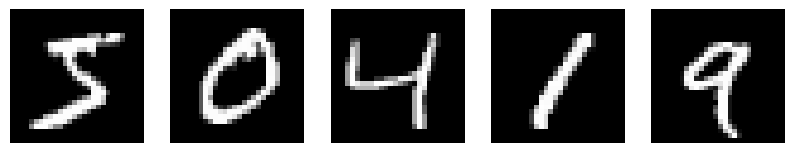

In [4]:
# Visualize the first 5 entries horizontally
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i in range(5):
    image, label = train_dataset[i]
    image = image.squeeze().numpy()
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

In [5]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

In [6]:
x_test, _ = next(iter(trainloader))
x_test = jnp.asarray(x_test)
t_test = jax.random.uniform(jax.random.PRNGKey(0), (batch_size,), minval=0., maxval=1.)
t_test

Array([0.9653214 , 0.22515893, 0.63302994, 0.29638183], dtype=float32)

## Diffusion model

### Task 6

Based on the information in Task 5, implement a function `standard_deviation(t, sigma)` that takes a batch of times `t` of shape `(N,)` and a scalar `sigma` and returns a batch of standard deviations of shape `(N,)`. Additionally, implement a function `diffusion_coefficient(t, sigma)` that takes a batch of times `t` of shape `(N,)` and a scalar `sigma` and returns a batch of diffusion coefficients of shape `(N,)`.

#### Answer

In [7]:
@jax.jit
def standard_deviation(times: , sigma):
    '''
    Description:
        Compute the standard deviation of the Gaussian diffusion process at a given time.
    
    Arguments:
        times: (batch_size, )
        sigma: (batch_size, )
        
    Returns:
        std_t: (batch_size, )
    '''
    std_t = ...
    return std_t

In [8]:
standard_deviation(t_test, 3.0)

Array([3.9496055, 0.6200967, 1.8566518, 0.7806793], dtype=float32)

In [9]:
@jax.jit
def diffusion_coefficient(times, sigma):
  '''
  Description:
      Compute the diffusion coefficient of the Gaussian diffusion process at a given time.
      
  Arguments:
      times: (batch_size, )
      sigma: (batch_size, ) 
      
  Returns:
      coef: (batch_size, )
  '''
  coef = ...
  return coef

In [10]:
diffusion_coefficient(t_test, 3.0)

Array([8.339706 , 1.6400467, 4.018501 , 1.9178745], dtype=float32)

### Task 7

Based on the implemented functions in Task 6 — `standard_deviation(t, sigma)` and `diffusion_coefficient(t, sigma)` — implement a function `forward_diffusion(x, t, sigma)` that takes a batch of images `x` of shape `(N, C, H, W)`, a batch of times `t` of shape `(N,)`, and a scalar `sigma` and returns a batch of forward diffusions of shape `(N, C, H, W)`.

#### Answer

In [11]:
@jax.jit
def forward_diffusion(rng, times, states, sigma):
    '''
    Description:
        Compute the forward diffusion process of the Gaussian diffusion process at a given time.
        
    Arguments:
        rng: random number generator
        times: (batch_size, )
        states: (batch_size, 1, 28, 28)
        sigma: (batch_size, )
        
    Returns:
        states: (batch_size, 1, 28, 28)
    '''
    noise = ...
    noised_states = states + noise
    return noised_states

In [12]:
forward_diffusion(jax.random.PRNGKey(0), t_test, x_test, 3.0).shape

(4, 1, 28, 28)

#### Execution of Task 7

In [13]:
def plot_diffused_images(rng, times, states, sigma):
    
    # Visualize the first num_images entries horizontally with added noise at different times
    fig, axes = plt.subplots(times.shape[0], states.shape[0], figsize=(10, 2 * times.shape[0]))
    
    # Iterate through times
    for i, t in enumerate(times):
        
        # Add noise to each image
        t = jnp.full((states.shape[0],), t)
        rng, _ = jax.random.split(rng)
        states_t = forward_diffusion(rng, t, states, sigma)
        
        # Iterate through images
        for j, state in enumerate(states_t):
            axes[i, j].imshow(state.squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.show()

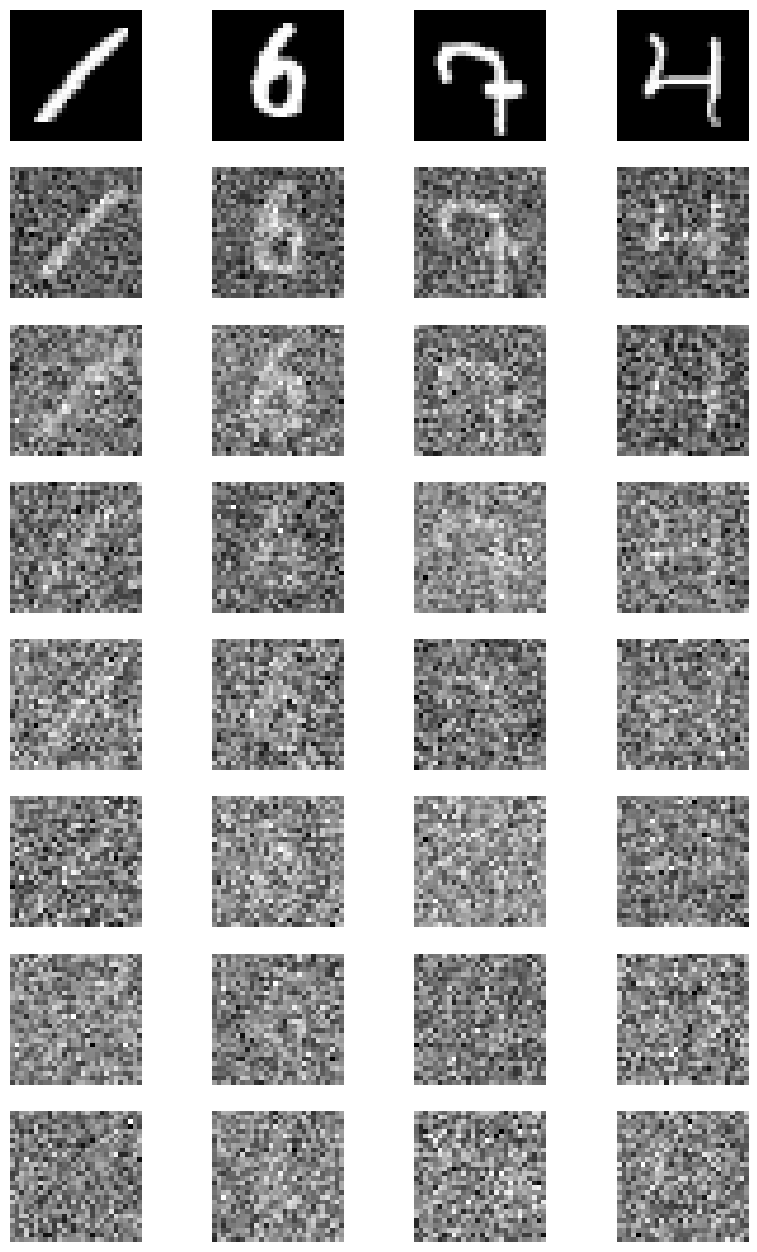

In [14]:
plot_diffused_images(
    jax.random.PRNGKey(0),
    jnp.linspace(0.0, 1.0, num=8),
    x_test,
    2.0
)

## Score model

A score function, within the context of generative models and especially in the context of score-based generative models, is a function that is trained to estimate the gradient of the log-likelihood of the data distribution at a given data point. This function, also referred to as a score network, can be used to generate new, synthetic data points that follow the same data distribution as the training data. Below we define a score model where time is embedded in a Gaussian-Fourier style.

The score function is a neural network trained to approximate the gradient of the log-likelihood of the data. Given a data point (an instance from the dataset), the score function outputs a vector (score) which points in the direction of the greatest increase in the log-likelihood. Essentially, it tells us how much we need to change the input to increase the probability of the data under the model. In the case of images, it provides a 'direction' to change each pixel to make the image more like those in the training dataset.

In [33]:
class ScoreModel(hk.Module):
    
    def __init__(self, hidden_units, sigma):
        super().__init__()
        self.hidden_units = hidden_units
        self.sigma = sigma

    def __call__(self, times, states):
        
        # Time embedding
        t = jnp.concatenate([
            jnp.sin(2 * jnp.pi * times)[:,None],
            jnp.cos(2 * jnp.pi * times)[:,None]
        ], axis=-1)
        t = hk.Linear(self.hidden_units)(t)
        t = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(t)
        t = jax.nn.swish(t)
        
        # State embedding
        x = jnp.transpose(states, (0, 2, 3, 1))
        x = hk.Conv2D(self.hidden_units, kernel_shape=3, padding='SAME')(x)
        x = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(x)
        x = jax.nn.swish(x)
        x = hk.Conv2D(self.hidden_units, kernel_shape=3, padding='SAME')(x)
        x = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(x)
        x = jax.nn.swish(x)
        
        # Incorporate time information
        x = x * t[:, None, None, :]
        x = hk.Conv2D(self.hidden_units, kernel_shape=3, padding='SAME')(x)
        x = hk.LayerNorm(axis=-1, create_scale=True, create_offset=True)(x)
        x = jax.nn.swish(x)
        x = hk.Conv2D(self.hidden_units, kernel_shape=3, padding='SAME')(x)
        x = jax.nn.swish(x)
        x = hk.Conv2D(self.hidden_units, kernel_shape=3, padding='SAME')(x)
        x = jax.nn.swish(x)
        x = hk.Conv2D(1, kernel_shape=3, padding='SAME')(x)
        
        # Output
        score = jnp.transpose(x, (0, 3, 1, 2))
        score = score / standard_deviation(times, self.sigma)[:, None, None, None]
        return score

In [34]:
score_model = hk.without_apply_rng(hk.transform(lambda t, x: ScoreModel(100, 2.0)(t, x)))
score_params = score_model.init(jax.random.PRNGKey(0), t_test, x_test)
score_model.apply(score_params, t_test, x_test)

Array([[[[ 0.        ,  0.        ,  0.        , ...,  0.02569626,
          -0.01244034,  0.01505509],
         [ 0.        ,  0.        ,  0.        , ..., -0.01852869,
          -0.05402343, -0.01663584],
         [ 0.        ,  0.        ,  0.        , ..., -0.01067307,
          -0.01538263, -0.0049607 ],
         ...,
         [-0.01493246, -0.01301005,  0.01279406, ...,  0.        ,
           0.        ,  0.        ],
         [-0.00380759, -0.0354537 , -0.02656401, ...,  0.        ,
           0.        ,  0.        ],
         [ 0.00869673, -0.00476548,  0.00795417, ...,  0.        ,
           0.        ,  0.        ]]],


       [[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.      

<!-- Now we will build the full score model using the U-Net architecture. In the model, we will use the Gaussian-Fourier embedding to represent the time input. The U-Net architecture is particularly useful for tasks such as image segmentation or generative modeling. Its unique design combines both contracting and expanding paths, allowing for the fusion of multi-scale information at different levels of abstraction. With skip connections, the U-Net captures both local and global context, preserving spatial information and effectively handling varying object sizes. This makes it well-suited for tasks that require understanding and processing of complex spatial structures, providing significant advantages over using just a Multi-Layer Perceptron (MLP). -->

## Loss function

### Task 8

In this task, you are tasked with implementing a function that computes the loss for a score-based generative model. Score-based generative models are a type of machine learning model that learn the gradient of the log-likelihood of the data distribution (the score), and can generate new data that is similar to the input data.

The function you will be implementing is called loss, and it takes four arguments: a random number generator rng (provided by jax.random.PRNGKey(seed)), the parameters of the score model params, the input data states (a batch of images, in the case of MNIST), and the standard deviation sigma of the noise to be added in the diffusion process.

In the body of this function, you should first sample random times t in the interval (0, 1) for each sample in the batch. Next, sample random noise z from a standard normal distribution with the same shape as the input states.

Then, compute the standard deviation std at each time t using the function standard_deviation(times, sigma). This standard deviation is then reshaped to match the shape of the input data. After computing the standard deviation, perturb the input data states by adding z scaled by the standard deviation.

Next, you'll need to compute the scores for the perturbed data using the score model. This involves calling score_model.apply(params, times, states_perturbed).

Finally, calculate the squared norm difference between z and the scores, scaled by the standard deviation, and return the mean of these values across all samples in the batch.

#### Answer

In [35]:
@jax.jit
def loss(rng, params, states, sigma):
    '''
    Description:
        Compute the loss of the score model.
        
    Arguments:
        rng: random number generator
        params: parameters of the score model
        states: (batch_size, 1, 28, 28)
        sigma: (batch_size, )
        
    Returns:
        loss: scalar
    '''
    
    # Sample random t in the interval (0, 1)
    rng, _ = jax.random.split(rng)
    times = jax.random.uniform(rng, (states.shape[0],), minval=0.0, maxval=1.0)

    # Sample random z from a normal distribution with the same shape as x
    rng, _ = jax.random.split(rng)
    noise = jax.random.normal(rng, states.shape)
    
    # Standard deviation
    std = standard_deviation(times, sigma)[:, None, None, None]

    # Perturb x by z scaled by the standard deviation
    states_perturbed = states + noise * std

    # Compute the scores using the score model
    scores = score_model.apply(params, times, states_perturbed)

    # Calculate the squared norm difference between z and the scores, scaled by the standard deviation
    loss = ...
    
    return loss

loss(jax.random.PRNGKey(0), score_params, x_test, 2.0)

Array(754.6283, dtype=float32)

## Training

In this section we will train the score model.

The main components of the code are the optimizer initialization, the training data loader setup, the definition of a single optimization step, and the training loop.

In [36]:
from jax.example_libraries import optimizers
from tqdm import tqdm

Optimizer Initialization: The code first initializes an Adam optimizer from the jax library with a learning rate of 1e-4. Three functions are returned by the optimizers.adam call: opt_init (initializes the optimizer state), opt_update (updates the optimizer state given the gradient), and get_params (extracts the current parameter values from the optimizer state). The optimizer state for the score model parameters (score_params) is then initialized using opt_init.

In [52]:
opt_init, opt_update, get_params = optimizers.adam(1e-4)

In [43]:
opt_state = opt_init(score_params)
losses = list()

Data Loader Setup: The code sets up a data loader for the training dataset. This loader shuffles the dataset and outputs batches of 50 samples each.

In [44]:
batch_size = 25
trainloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

Optimization Step Definition: The step function is defined to perform one optimization step. This function takes the iteration count, a random number generator, the current optimizer state, a batch of input states, and the noise standard deviation as arguments. Inside the function, the value of the loss function and its gradient with respect to the score model parameters are computed using jax.value_and_grad. The optimizer state is then updated using opt_update and the updated optimizer state along with the loss value are returned.

In [53]:
@jax.jit
def step(i, rng, opt_state, states, sigma):
    value, grads = jax.value_and_grad(loss, argnums=1)(rng, get_params(opt_state), states, sigma)
    return opt_update(i, grads, opt_state), value

Training Loop: The main part of the code is the training loop, which iterates over a specified number of steps (num_steps). In each iteration:

A batch of input states is sampled from the data loader.
A new random key is generated using jax.random.split.
One optimization step is performed using the step function, updating the optimizer state and returning the current loss value.
The updated parameters are extracted from the optimizer state using get_params.
The current loss value is appended to a list to keep track of the loss during training, and it is also displayed in the progress bar.

In [ ]:
# Training loop
num_steps = 10000
pbar = tqdm(range(num_steps), desc="Training progress")
rng = jax.random.PRNGKey(0)
for i in pbar:
    
    # Random sample
    states, _ = next(iter(trainloader))
    states = jnp.asarray(states)
    
    # Random key
    rng, _ = jax.random.split(rng)
    opt_state, value = step(i, rng, opt_state, states, 2.0)
    score_params = get_params(opt_state)
    
    # Record
    losses.append(value)
    pbar.set_postfix({'loss': value})
    
pbar.close()

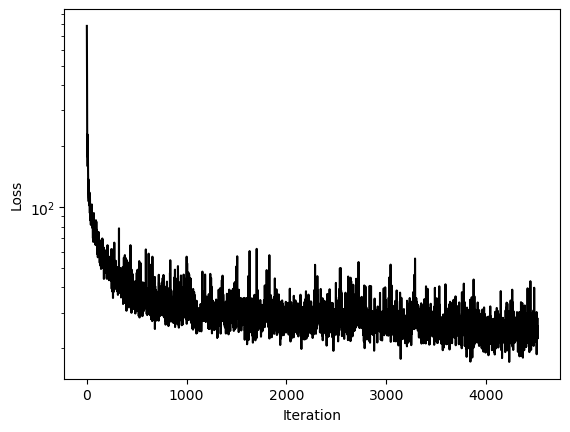

In [55]:
fig, ax = plt.subplots(1)
ax.plot(losses, 'k-')
ax.set_yscale('log')
ax.set(xlabel='Iteration', ylabel='Loss')
# ax.set_xscale('log')
plt.show()

## Sampling

As we showed in the introduction, the reverse-time SDE is given by
$$
dx(t) = \left[f(x(t), t) - g^2(t) \underbrace{\nabla_x \log  p(x(t))}_{S(x(t))}\right]dt + g(t)d \overline{w}.
$$
Since we have chosen our diffusion coefficient as $g(t) = \sigma^{2t}$, our reverse-time SDE is:
$$
dx(t) = -\sigma^{4t} \hat S(\theta, t, x) dt + \sigma^{2t}d \overline{w}.
$$

Now, let's sample from the terminal distribution of the forward diffusion process
$$
x(1) \sim \mathcal{N}\left(0, \frac{\sigma^{4} - 1}{4 \log \sigma} I\right).
$$

Then we can simulate the reverse diffusion process using [Euler-Maruyama integration](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)
$$
x_{t-\Delta t} = x_t + \sigma^{4t} \hat S(\theta, t, x) \Delta t + \sigma^{2t} \sqrt{\Delta t}z,
$$
where $z \sim \mathcal{N}(0, I)$, where note the change in sign due to a negative time step.

### Task 9

In this task, your goal is to implement a function that uses the Euler-Maruyama integration method to generate samples from the data distribution using a reverse diffusion process. Your function should take as input a random number generator, a set of parameters for the score model, a batch size, a number of steps, and a standard deviation for the noise, and return a batch of samples.

Your function should perform the following steps:

- Initialization: Start by generating a batch of samples from a standard normal distribution. The shape of the samples should be `(batch_size, 1, 28, 28)`. Scale these samples by the standard deviation corresponding to a time of 1 (use the standard_deviation function with an array of ones of size `(batch_size,)` and the given sigma).
- Reverse Diffusion: Implement the reverse diffusion process using the Euler-Maruyama integration method. This process should operate over a number of time steps, specified by num_steps, from 1 to a small positive number (like `1e-5`). In each time step: 
Compute the diffusion coefficient `g` for the current time (use the diffusion_coefficient function with the current time and sigma).
Compute the mean x_mean of the next step's distribution by adding to the current samples the product of `g**2`, the score of the current samples (computed with the score model), and the time step size dt.
Update the samples by adding to `x_mean` a random noise scaled by `g` and the square root of `dt`.

The function should have the signature `sample(rng, params, batch_size, num_steps, sigma)`.

#### Answer

In [56]:
def sample(rng, params, batch_size, num_steps, sigma):
    
    '''
    Description:
        Sample from the diffusion model using the Euler-Maruyama method.
        
    Arguments:
        rng: random number generator
        params: parameters of the score model
        batch_size: number of samples
        num_steps: number of steps
        sigma: (batch_size, )
        
    Returns:
        x_mean: (batch_size, 1, 28, 28)
    '''
    
    # Random key
    rng, _ = jax.random.split(rng)
    
    # Prior sample
    x = jax.random.normal(rng, (batch_size, 1, 28, 28))
    x = x*standard_deviation(jnp.ones((batch_size,)), sigma)[:, None, None, None]
    
    # Reverse diffusion
    t = jnp.linspace(1.0, 1e-5, num_steps)
    dt = t.max() / num_steps
    pbar = tqdm(range(len(t)), desc="Reverse diffusion")
    for i in pbar:
        ti = jnp.ones((batch_size,))*t[i]
        g = diffusion_coefficient(ti, sigma)[:, None, None, None]
        x_mean = x + ...
        rng, _ = jax.random.split(rng)
        x = x_mean + ...
        pbar.set_postfix({'t': t[i]})
    return x_mean

#### Execution of Task 9

In [57]:
# Get a batch of samples from the generative model (5 images)
x = sample(jax.random.PRNGKey(0), score_params, 5, 2000, 2.0)

Reverse diffusion: 100%|██████████| 2000/2000 [01:51<00:00, 18.01it/s, t=1e-05]       


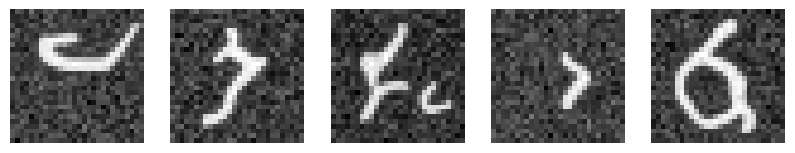

In [58]:
# Visualize the first N entries horizontally
N = x.shape[0]  # number of images in the batch
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))

for i in range(N):
    image = x[i, 0, :, :]  # Fetch the image
    image = image.copy()  # JAX arrays are immutable, so we make a copy for the plotting library
    
    # Assuming you have a corresponding array of labels named `labels`
    # label = labels[i]

    axes[i].imshow(image, cmap='gray')
    # axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()
